In [1]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, CSVLogger
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
matplotlib.use('Qt4Agg')
from imageio import imread
from keras.preprocessing import image

from models.keras_ssd7 import build_model
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms
from data_generator.data_augmentation_chain_variable_input_size import DataAugmentationVariableInputSize
from data_generator.data_augmentation_chain_constant_input_size import DataAugmentationConstantInputSize
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from keras.models import model_from_json

Using TensorFlow backend.


In [20]:
img_height = 698 # Height of the input images
img_width = 698 # Width of the input images
img_channels = 3 # Number of color channels of the input images
intensity_mean = 127.5 # Set this to your preference (maybe `None`). The current settings transform the input pixel values to the interval `[-1,1]`.
intensity_range = 127.5 # Set this to your preference (maybe `None`). The current settings transform the input pixel values to the interval `[-1,1]`.
n_classes = 1 # Number of positive classes
scales = [0.08, 0.16, 0.32, 0.64, 0.96] # An explicit list of anchor box scaling factors. If this is passed, it will override `min_scale` and `max_scale`.
aspect_ratios = [0.5, 1.0, 2.0] # The list of aspect ratios for the anchor boxes
two_boxes_for_ar1 = True # Whether or not you want to generate two anchor boxes for aspect ratio 1
steps = None # In case you'd like to set the step sizes for the anchor box grids manually; not recommended
offsets = None # In case you'd like to set the offsets for the anchor box grids manually; not recommended
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [1.0, 1.0, 1.0, 1.0] # The list of variances by which the encoded target coordinates are scaled
normalize_coords = True # Whether or not the model is supposed to use coordinates relative to the image size


In [21]:
model_path = 'b100e50s40.h5'

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'DecodeDetections': DecodeDetections,
                                               'compute_loss': ssd_loss.compute_loss})

In [22]:
orig_images = [] # Store the images here.
input_images = [] # Store resized versions of the images here.

# We'll only load one image in this example.
img_path = 'Part31.jpg'

orig_images.append(imread(img_path))
img = image.load_img(img_path, target_size=(img_height, img_width))
img = image.img_to_array(img) 
input_images.append(img)
input_images = np.array(input_images)

In [23]:
y_pred = model.predict(input_images)

In [24]:
confidence_threshold = 0.16
# y_pred_thresh= np.reshape(y_pred_thresh,(39836,18))
# print(np.shape(y_pred_thresh))
y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]
print(y_pred[0,:,1])
np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(np.shape(y_pred_thresh))
# print(y_pred_thresh[0])
# y=y_pred_thresh[0]
# y=y[10000:12000]
# np.shape(y_pred_thresh)
# y=np.unique(y ,axis=0)
# y_pred_thresh=[y]
# print(y[0])
# print(y_pred_thresh[0][0])

[0.33 0.33 0.33 ... 0.33 0.33 0.33]
Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
(1, 39836, 15)


In [25]:
import cv2
import numpy as np

# from colors import label_color


def draw_box(image, box, color, thickness=2):
    """ Draws a box on an image with a given color.
    # Arguments
        image     : The image to draw on.
        box       : A list of 4 elements (x1, y1, x2, y2).
        color     : The color of the box.
        thickness : The thickness of the lines to draw a box with.
    """
    b = np.array(box).astype(int)
    cv2.rectangle(image, (b[0], b[1]), (b[2], b[3]), (0,0,255), thickness, cv2.LINE_AA)

In [26]:
def draw_caption(image, box, caption):
    """ Draws a caption above the box in an image.
    # Arguments
        image   : The image to draw on.
        box     : A list of 4 elements (x1, y1, x2, y2).
        caption : String containing the text to draw.
    """
    b = np.array(box).astype(int)
    cv2.putText(image, 'weed', (b[0], b[1]), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 0), 2)
    cv2.putText(image, 'weed', (b[0], b[1]), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 1)

In [27]:
# colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
classes = ['background']

# plt.figure(figsize=(20,12))
# plt.imshow(orig_images[0])

# current_axis = plt.gca()

for box in y_pred_thresh[0]:
    draw = img.copy()
    color = 1
    b = box.astype(int)
    draw_box(draw, b, color=color)
#     draw_caption(draw, b,'weed')



cv2.imwrite('output.jpg',draw)
# plt.imshow(draw)
# plt.show()
    # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
    #     xmin = box[2] * orig_images[0].shape[1] / img_width
    #     ymin = box[3] * orig_images[0].shape[0] / img_height
    #     xmax = box[4] * orig_images[0].shape[1] / img_width
    #     ymax = box[5] * orig_images[0].shape[0] / img_height
#     xmin = box[2]
#     ymin = box[3]
#     xmax = box[4]
#     ymax = box[5]
#     color = colors[int(box[0])]
#     label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
#     current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
#     current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})


True

In [31]:
train_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)

images_dir = '/Users/rohanbanerjee/Documents/ssd_keras/images/'

# Ground truth
train_labels_filename = '/Users/rohanbanerjee/Documents/ssd_keras/dataset/train.csv'
val_labels_filename   = '/Users/rohanbanerjee/Documents/ssd_keras/dataset/test.csv'

train_dataset.parse_csv(images_dir=images_dir,
                        labels_filename=train_labels_filename,
                        input_format=['image_name', 'xmin', 'ymin', 'xmax', 'ymax', 'class_id'], # This is the order of the first six columns in the CSV file that contains the labels for your dataset. If your labels are in XML format, maybe the XML parser will be helpful, check the documentation.
                        include_classes='all')

val_dataset.parse_csv(images_dir=images_dir,
                      labels_filename=val_labels_filename,
                      input_format=['image_name', 'xmin', 'ymin', 'xmax', 'ymax', 'class_id'],
                      include_classes='all')

train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

predict_generator = val_dataset.generate(batch_size=1,
                                         shuffle=True,
                                         transformations=[],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'processed_labels',
                                                  'filenames'},
                                         keep_images_without_gt=False)

batch_images, batch_labels, batch_filenames = next(predict_generator)

i = 0 # Which batch item to look at

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(batch_labels[i])

Image: /Users/rohanbanerjee/Documents/ssd_keras/images/Part24.jpg

Ground truth boxes:

[[  0  23 329  53 365]
 [  0  28 399  58 435]
 [  0  32  42  62  78]
 [  0  35 471  65 507]
 [  0  37 580  67 616]
 [  0  47  96  77 132]
 [  0  50 661  80 697]
 [  0  64 256  94 292]
 [  0  71 303 101 339]
 [  0  75 377 105 413]
 [  0  81 438 111 474]
 [  0  92  80 122 116]
 [  0  94 498 124 534]
 [  0 102 565 132 601]
 [  0 112 623 142 659]
 [  0 121 296 151 332]
 [  0 128 348 158 384]
 [  0 130 398 160 434]
 [  0 137 458 167 494]
 [  0 140  80 170 116]
 [  0 147 509 177 545]
 [  0 150 172 180 208]
 [  0 156 565 186 601]
 [  0 166 261 196 297]
 [  0 166 613 196 649]
 [  0 174 307 204 343]
 [  0 177 364 207 400]
 [  0 183 418 213 454]
 [  0 202 496 232 532]
 [  0 210 559 240 595]
 [  0 221 633 251 669]
 [  0 251  26 281  62]
 [  0 251 151 281 187]
 [  0 263 249 293 285]
 [  0 273 340 303 376]
 [  0 286 443 316 479]
 [  0 297 143 327 179]
 [  0 311 237 341 273]
 [  0 312 280 342 316]
 [  0 320 336 3

23 329 53 365
28 399 58 435
32 42 62 78
35 471 65 507
37 580 67 616
47 96 77 132
50 661 80 697
64 256 94 292
71 303 101 339
75 377 105 413
81 438 111 474
92 80 122 116
94 498 124 534
102 565 132 601
112 623 142 659
121 296 151 332
128 348 158 384
130 398 160 434
137 458 167 494
140 80 170 116
147 509 177 545
150 172 180 208
156 565 186 601
166 261 196 297
166 613 196 649
174 307 204 343
177 364 207 400
183 418 213 454
202 496 232 532
210 559 240 595
221 633 251 669
251 26 281 62
251 151 281 187
263 249 293 285
273 340 303 376
286 443 316 479
297 143 327 179
311 237 341 273
312 280 342 316
320 336 350 372
322 401 352 437
341 474 371 510
357 580 387 616
358 214 388 250
361 268 391 304
363 331 393 367
374 382 404 418
377 21 407 57
380 428 410 464
381 67 411 103
395 179 425 215
395 529 425 565
412 250 442 286
429 365 459 401
439 456 469 492
454 564 484 600
465 317 495 353
477 433 507 469
496 171 526 207
497 528 527 564
500 579 530 615
502 231 532 267
506 647 536 683
518 300 548 336
540 503

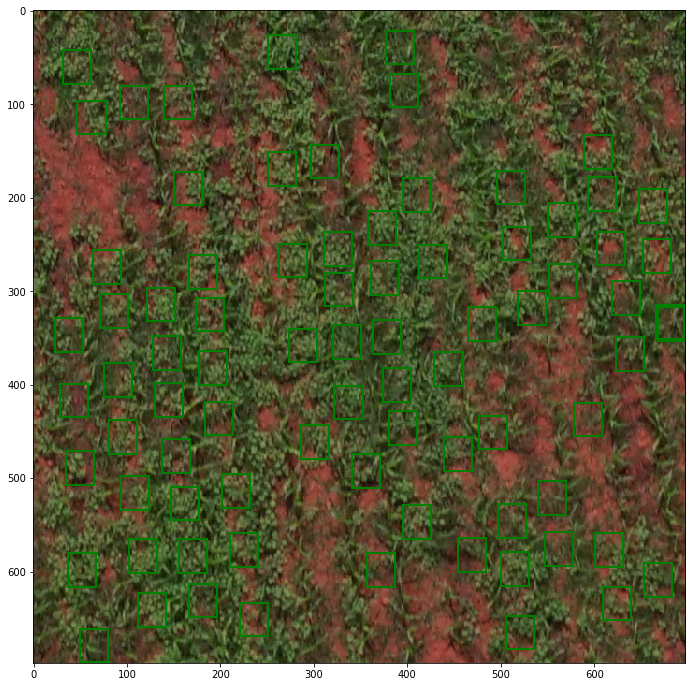

In [32]:
plt.figure(figsize=(20,12))
plt.imshow(batch_images[i])

current_axis = plt.gca()

colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist() # Set the colors for the bounding boxes
classes = ['background'] 

for box in batch_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    print(box[1],box[2],box[3],box[4])
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2)) 